In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm

# Load aspect-based data
df_aspect = pd.read_csv('DATA ASPEK BARU.csv')

# Preprocess aspect-based data (adjust column names based on your CSV)
def preprocess_aspect_data(df):
    df['ulasan'] = df['ulasan'].str.lower()  # Lowercase text
    df['ulasan'] = df['ulasan'].str.replace(r'[^\w\s]', '', regex=True)  # Remove punctuation
    return df

df_aspect = preprocess_aspect_data(df_aspect)

# Mapping aspect-specific labels to integers
aspect_label_map = {aspect: idx for idx, aspect in enumerate(df_aspect['aspek'].unique())}
df_aspect['aspect_label'] = df_aspect['aspek'].map(aspect_label_map)

# Combine content and aspect as input for the model
df_aspect['ulasan'] = df_aspect['aspek'] + " [ASPECT] " + df_aspect['ulasan']

# Tokenize aspect-based data
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
encoded_data_aspect = tokenizer.batch_encode_plus(
    df_aspect['ulasan'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=256,
    return_tensors='pt'
)

# Prepare labels and tensors
labels_aspect = torch.tensor(df_aspect['aspect_label'].values)
input_ids_aspect = encoded_data_aspect['input_ids']
attention_masks_aspect = encoded_data_aspect['attention_mask']

# Split data into train (80%), validation (10%), and test (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    input_ids_aspect, labels_aspect, test_size=0.2, random_state=42, stratify=labels_aspect
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_train_np = X_train.numpy()
X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train_np.reshape(X_train_np.shape[0], -1), y_train.numpy()
)

# Convert back to torch tensors after SMOTE
input_ids_train_resampled = torch.tensor(X_train_resampled)
attention_masks_train_resampled = torch.ones(input_ids_train_resampled.shape, dtype=torch.long)

# Create DataLoader
def create_dataloader(inputs, masks, labels, batch_size):
    data = TensorDataset(inputs, masks, labels)
    sampler = RandomSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    return dataloader

batch_size = 64
dataloader_train = create_dataloader(input_ids_train_resampled, attention_masks_train_resampled, torch.tensor(y_train_resampled), batch_size)
dataloader_val = create_dataloader(X_val, attention_masks_aspect[:len(X_val)], y_val, batch_size)
dataloader_test = create_dataloader(X_test, attention_masks_aspect[:len(X_test)], y_test, batch_size)

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased', num_labels=len(aspect_label_map))

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 10
total_steps = len(dataloader_train) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training and evaluation loop
def train_model():
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        model.train()
        total_loss = 0
        train_progress = tqdm(dataloader_train, desc="Training", leave=False)
        for batch in train_progress:
            batch = tuple(b.to(device) for b in batch)
            optimizer.zero_grad()
            outputs = model(batch[0], attention_mask=batch[1], labels=batch[2])
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_progress.set_postfix({'Batch Loss': loss.item()})
        print(f"Training Loss: {total_loss / len(dataloader_train)}")

        model.eval()
        val_loss = 0
        predictions, true_labels = [], []
        val_progress = tqdm(dataloader_val, desc="Validating", leave=False)
        for batch in val_progress:
            batch = tuple(b.to(device) for b in batch)
            with torch.no_grad():
                outputs = model(batch[0], attention_mask=batch[1], labels=batch[2])
                val_loss += outputs.loss.item()
                logits = outputs.logits
                predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
                true_labels.extend(batch[2].cpu().numpy())
        val_f1 = f1_score(true_labels, predictions, average='weighted')
        print(f"Validation Loss: {val_loss / len(dataloader_val)} | F1 Score: {val_f1}")

train_model()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/10


Training Loss: 0.2861254611732464


Validation Loss: 0.4088983703404665 | F1 Score: 0.8417941557119157

Epoch 2/10


Training Loss: 0.010802092702838672


Validation Loss: 0.30338875111192465 | F1 Score: 0.8838399930413682

Epoch 3/10


Training Loss: 0.005151282961944698


Validation Loss: 0.25864547211676836 | F1 Score: 0.9035155936887371

Epoch 4/10


Training Loss: 0.0032748244709230076


Validation Loss: 0.26236090203747153 | F1 Score: 0.9044957609293737

Epoch 5/10


Training Loss: 0.002377690055302393


Validation Loss: 0.265655227471143 | F1 Score: 0.9044957609293737

Epoch 6/10


Training Loss: 0.0018531115544118378


Validation Loss: 0.2697016913443804 | F1 Score: 0.905475661402575

Epoch 7/10


Training Loss: 0.0015326276846158193


Validation Loss: 0.27102223271504045 | F1 Score: 0.9074347045158462

Epoch 8/10


Training Loss: 0.0027950326116760738


Validation Loss: 0.21903475048020482 | F1 Score: 0.9349061605125634

Epoch 9/10


Training Loss: 0.001403496288001722


Validation Loss: 0.2129675797186792 | F1 Score: 0.9348018831945923

Epoch 10/10


Training Loss: 0.0012618839540634273


Validation Loss: 0.21369862277060747 | F1 Score: 0.9357788662044894


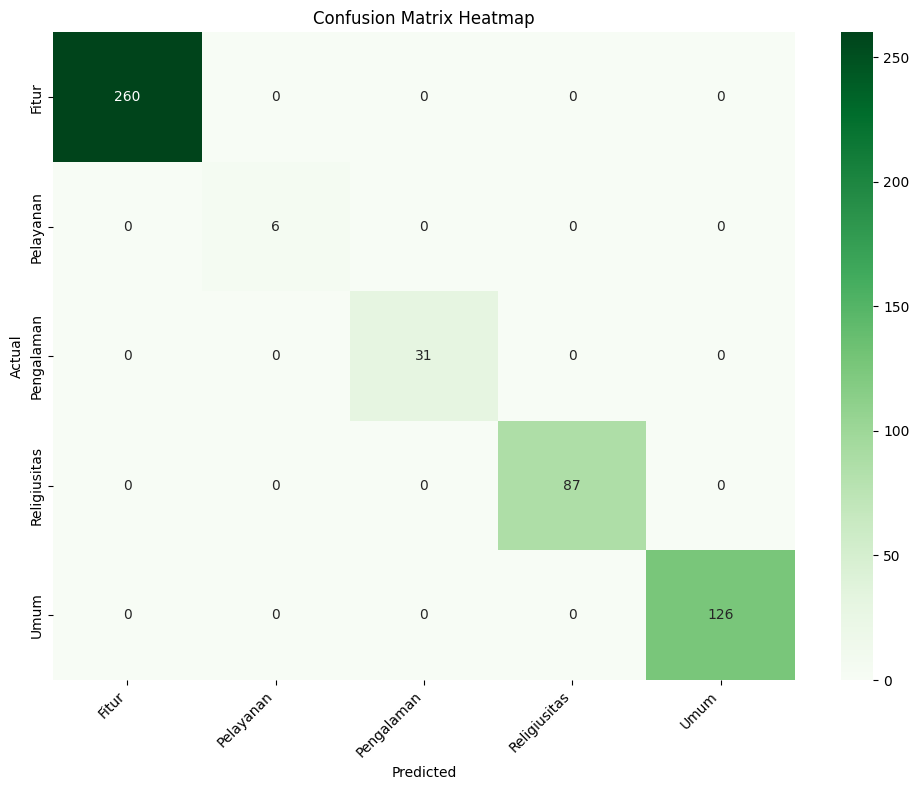

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import torch

def evaluate_confusion_matrix_with_heatmap(model, dataloader, label_map, device, exclude_label='General'):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            # Move data to device (CPU/GPU)
            batch = tuple(b.to(device) for b in batch)

            # Get predictions
            outputs = model(batch[0], attention_mask=batch[1])
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(batch[2].cpu().numpy())

    # Find the index of the label to exclude
    exclude_idx = label_map.get(exclude_label)

    # Filter indices for labels excluding `exclude_label`
    filtered_labels = [label for label, idx in label_map.items() if idx != exclude_idx]

    # Create confusion matrix without the excluded label
    filtered_indices = [label_map[label] for label in filtered_labels]
    cm = confusion_matrix(true_labels, predictions, labels=filtered_indices)

    # Plot heatmap of the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Greens',
        xticklabels=filtered_labels,
        yticklabels=filtered_labels
    )
    plt.xticks(rotation=45, ha='right')  # Rotate x-labels to avoid overlap
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heatmap')
    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

    return cm

# Evaluate on test data
cm_test = evaluate_confusion_matrix_with_heatmap(model, dataloader_test, aspect_label_map, device, exclude_label='General')

In [ ]:
import torch

# Kalimat yang ingin diprediksi
kalimat = 'aplikasi lengkap dan bagus, terus tingkat kan biar lebih baik lagi...'

# Tambahkan token aspek jika digunakan saat pelatihan
aspect_token = '[ASPECT]'  # Sesuaikan jika menggunakan token khusus
input_text = f'{predicted_aspect} {aspect_token} {kalimat}'

# Tokenisasi kalimat dengan tokenizer yang digunakan saat pelatihan
encoded_data = tokenizer.encode_plus(
    input_text,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=256,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids'].to(device)
attention_mask = encoded_data['attention_mask'].to(device)

# Prediksi aspek menggunakan model pelatihan di atas
with torch.no_grad():
    model.eval()
    outputs_aspect = model(input_ids, attention_mask=attention_mask)
    logits_aspect = outputs_aspect.logits
    predictions_aspect = torch.argmax(logits_aspect, dim=1).cpu().numpy()

# Prediksi aspek telah dilakukan, sekarang gunakan model sentimen
with torch.no_grad():
    model_sentiment.eval()
    outputs_sentiment = model_sentiment(input_ids, attention_mask=attention_mask)
    logits_sentiment = outputs_sentiment.logits
    predictions_sentiment = torch.argmax(logits_sentiment, dim=1).cpu().numpy()

# Pastikan kamus aspek dan sentimen sesuai dengan pelatihan
aspect_dict = {v: k for k, v in aspect_label_map.items()}  # Aspek

# Tampilkan hasil prediksi
predicted_aspect_num = predictions_aspect[0]
predicted_aspect = aspect_dict[predicted_aspect_num]

predicted_sentiment_num = predictions_sentiment[0]
predicted_sentiment = sentiment_dict[predicted_sentiment_num]

print(f'Kalimat: {kalimat}')
print(f'Aspek Prediksi: {predicted_aspect}')


Kalimat: aplikasi lengkap dan bagus, terus tingkat kan biar lebih baik lagi...
Aspek Prediksi: Fitur
